In [ ]:
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

In [ ]:
import numpy as np
X1 = np.loadtxt("results/mse_data_with_fourier.txt")
print(f"{X1.mean():e}")
print(f"{X1.std():e}")
print(f"{X1.max():e}")

In [ ]:
X2 = np.loadtxt("results/rmse_data_no_fourier.txt")
print(f"{X2.mean():e}")
print(f"{X2.std():e}")

In [ ]:
X2 = np.loadtxt("results/rmse_data_multi_dim.txt")
print(f"{X2.mean():e}")
print(f"{X2.std():e}")

In [ ]:
X = np.load("results_backwards/average_sigma_backwards.npy")
plt.plot(X[0,:])

In [ ]:
X = np.load("results_backwards/average_loss_backwards.npy")
print(X.shape)
n = X.shape[0] // 2
x = np.arange(0, n)
plt.plot(x, X[:n, 1])
plt.plot(x[1000:], X[1000:n, 0])
plt.yscale("log")

In [ ]:
plt.scatter(X[:,0], X[:,1], c = X[:, 2])
plt.colorbar()

In [ ]:
X = np.load("important_results_backwards/sigmas_batch.npy")
weights = [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
batch_PDE=[512, 1024, 2048, 4096, 8192]
batch_target=[8, 16, 32, 64]


for i in range(0, 10):
    plt.plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")

#plt.ylim([0, 0.6])
#plt.yscale("log")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
#plt.legend()

In [ ]:
X = np.load("important_results_backwards/sigmas_batch_fine.npy")
batch_PDE=[128, 256, 512, 1024]
batch_target=[32, 64, 96, 128]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(min(8, X.shape[0])):
    ax[0].plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")
ax[0].legend()

for i in range(8, min(20, X.shape[0])):
    ax[1].plot(X[i, :], label = f"PDE = {batch_PDE[i // len(batch_target)]}, batch = {batch_target[i % len(batch_target)]}")

ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.show()
#plt.ylim([0, 0.6])
#plt.yscale("log")
#plt.legend()

In [ ]:
scale = ["0.0", "1e-06", "1e-05", "0.0001", "0.001", "0.01", "0.1", "1.0", "10", "100", "1000"]
weights = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]
for i, s in enumerate(scale):
    X = np.load(f"results_backwards/average_sigma_scale_{s}.npy")
    plt.plot(X[0], label = weights[i])
plt.legend()

In [ ]:
scale = ["1.0", "10", "100", "1000"] # ["0.0", "1e-06", "1e-05", "0.0001", "0.001", "0.01", "0.1", 
weights = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100, 1000]

fig, ax = plt.subplots(3,1)

for s in scale:
    X = np.load(f"results_backwards/average_loss_scale_{s}.npy")
    #print(X.shape)
    ax[0].plot(X[:10_000, 0], label = s)
    ax[1].plot(X[:10_000, 1], label = s)
    ax[2].plot(X[:10_000, 1] + X[:10_000, 0], label = s)

ax[0].legend()
ax[1].legend()
ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].legend()
ax[2].set_yscale("log")

In [ ]:
from src.data_generator import DataGeneratorEuropean1D, DataGeneratorEuropeanMultiDimensional
import numpy as np
import matplotlib.pyplot as plt
import torch
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from src.PINN import PINNforwards
config = {}
config["K"] = 10
config["t_range"] = [0, 1]
config["S_range"] = np.array([[0, 100],
                              [0, 90],
                              [0, 80],
                              [0, 70]])

config["sigma"] = np.array([[0.05, 0.05, 0.1, 0.15, 0.1],
                            [0.01, 0.1, 0.05, 0.05, 0.01],
                            [0.01, 0.05, 0.1, 0.1, 0.15],
                            [0.05, 0.1, 0.05, 0.15, 0.1],
                            [0.1, 0.1, 0.01, 0.05, 0.05]])
N = 1
config["sigma"] = np.full((N,N), 0.075)
#config["cov"] = config["sigma"]@config["sigma"].T
#config["cov_torch"] = torch.tensor(config["cov"]).to(DEVICE)
config["r"] = 0.04

sigma_eff_sq = 0

for j in range(config["sigma"].shape[0]):
    tmp = 0
    for i in range(config["sigma"].shape[0]):
        tmp += config["sigma"][i, j]
    sigma_eff_sq += tmp**2

sigma_eff_sq /= config["sigma"].shape[0]**2
print(sigma_eff_sq)
# print(sigma_eff_sq)
sigma_eff = np.sqrt(sigma_eff_sq)
def create_validation_data(dataloader:
                           DataGeneratorEuropean1D, N_validation: int, config: dict) -> dict:
    w_expiry = 1
    w_lower = 1
    w_upper = 1

    validation_data = {}

    expiry_x_tensor_validation, expiry_y_tensor_validation = dataloader.get_expiry_time_tensor(
        N_validation, w_expiry)
    expiry_x_tensor_validation_scaled = dataloader.normalize(
        expiry_x_tensor_validation)
    # config["encoder"](expiry_x_tensor_validation)

    validation_data["expiry_x_tensor_validation"] = expiry_x_tensor_validation.to(
        DEVICE)
    validation_data["expiry_x_tensor_validation_scaled"] = expiry_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["expiry_y_tensor_validation"] = expiry_y_tensor_validation.to(
        DEVICE)

    lower_x_tensor_validation, lower_y_tensor_validation, upper_x_tensor_validation, upper_y_tensor_validation = dataloader.get_boundary_data_tensor(
        N_validation, w_lower, w_upper)
    lower_x_tensor_validation_scaled = dataloader.normalize(
        lower_x_tensor_validation)

    # config["encoder"](
    #    lower_x_tensor_validation)
    upper_x_tensor_validation_scaled = dataloader.normalize(
        upper_x_tensor_validation)

    # config["encoder"](    upper_x_tensor_validation)

    validation_data["lower_x_tensor_validation"] = lower_x_tensor_validation.to(
        DEVICE)
    validation_data["lower_x_tensor_validation_scaled"] = lower_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["lower_y_tensor_validation"] = lower_y_tensor_validation.to(
        DEVICE)

    validation_data["upper_x_tensor_validation"] = upper_x_tensor_validation.to(
        DEVICE)
    validation_data["upper_x_tensor_validation_scaled"] = upper_x_tensor_validation_scaled.to(
        DEVICE)
    validation_data["upper_y_tensor_validation"] = upper_y_tensor_validation.to(
        DEVICE)

    X1_validation, y1_validation = dataloader.get_pde_data_tensor(
        N_validation)
    X1_validation_scaled = dataloader.normalize(X1_validation)
    # config["encoder"](X1_validation)

    validation_data["X1_validation"] = X1_validation

    validation_data["X1_validation_scaled"] = X1_validation_scaled

    validation_data["y1_validation"] = y1_validation

    return validation_data

In [ ]:
dataloader1D = DataGeneratorEuropean1D([0,1], [0, 600], 30, 0.04, sigma_eff, DEVICE, seed = 2024)
torch.manual_seed(2024)
np.random.seed(2024)
dataloaderMulti = DataGeneratorEuropeanMultiDimensional(
        time_range=config["t_range"], S_range=config["S_range"], K=config["K"], r=config["r"], sigma=config["sigma"], DEVICE=DEVICE, seed=2024)

validation_data = create_validation_data(
    dataloader=dataloaderMulti, N_validation=1024, config=config)

test_data = create_validation_data(
    dataloader=dataloaderMulti, N_validation=20_000, config=config)

In [ ]:
model = PINNforwards(5, 1, 256, 4, use_fourier_transform=False, sigma_FF=5.0, encoded_size=512)
model.load_state_dict(torch.load("models/learning_0.001_512.pth", weights_only=True))
pde_X_scaled = test_data["X1_validation_scaled"]
pde_X = test_data["X1_validation"]

y_pde = model(pde_X_scaled).cpu().detach().numpy().ravel()
y1 = dataloaderMulti.get_analytical_solution(pde_X[:, 1:], pde_X[:, 0])

print(np.sqrt(np.mean((y1 - y_pde)**2)))

In [ ]:
y_tmp = dataloader1D.get_analytical_solution( torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1)), pde_X[:, 0])
print(np.mean(np.abs(y_tmp - y1)))

In [ ]:
X_loss = np.load("results/loss_learning_0.001_512.npy")
X_validation = np.load("results/validation_learning_0.001_512.npy")

types_of_loss = ["total_loss", "loss_boundary","loss_pde", "loss_expiry", "loss_lower", "loss_upper"]

for i in range(len(types_of_loss)):
    plt.plot(X_validation[::10, i], label = types_of_loss[i])
plt.yscale("log")
plt.legend()

In [ ]:
X_geometric = torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1))
X_tmp = X_geometric.cpu().detach().numpy()
time = pde_X[:, 0].cpu().detach().numpy()
mask = np.where(time <= 1.0) 

#y_1d= dataloader1D.get_analytical_solution(X_geometric, pde_X[:, 0])
plt.scatter(time[mask], X_tmp[mask], c = y1[mask])
plt.colorbar()
plt.show()
plt.scatter(time[mask], X_tmp[mask], c = y_pde[mask])
plt.colorbar()
plt.show()

In [ ]:
from matplotlib.colors import LogNorm
mask = np.where(time <= 1.0) 
plt.scatter(time[mask], X_tmp[mask], c = np.abs(y1[mask] - y_pde[mask]), norm=LogNorm())
#plt.scatter(time[mask], X_tmp[mask], c = y_pde[mask])
print(np.sqrt(np.mean((y1[mask] - y_pde[mask])**2)))
plt.colorbar()

In [ ]:
pde_X = test_data["X1_validation"]
y1 = dataloaderMulti.get_analytical_solution(pde_X[:, 1:], pde_X[:, 0])
X_geometric = torch.exp(torch.mean(torch.log(pde_X[:, 1:]), dim = 1))
y2 = dataloader1D.get_analytical_solution(X_geometric, pde_X[:, 0])

print(np.mean((y1 - y2)**2))

In [ ]:
np.mean(G - X_geometric.cpu().detach().numpy())
#X_geometric

In [ ]:
tmp_X1 = X_geometric.cpu().detach()
tmp_X2 = pde_X.cpu().detach()
plt.scatter(tmp_X2[:, 0], tmp_X1, c = y2, label = "1D")
plt.colorbar()
plt.legend()

In [ ]:
plt.scatter(tmp_X2[:, 0], tmp_X1, c = y1, label = "Multi")
plt.colorbar()
plt.legend()

In [2]:
import numpy as np
X = np.loadtxt("results/rmse_data_no_fourier.txt")
print(f"{X.mean():e}, {X.std():e}")
X = np.loadtxt("results/rmse_data_with_fourier.txt")
print(f"{X.mean():e}, {X.std():e}")
X = np.loadtxt("results/rmse_data_american_multiple.txt")
print(f"{X.mean():e}, {X.std():e}")

5.655081e-03, 7.472598e-04
4.599334e-03, 7.670261e-04
5.827621e-02, 7.282253e-03


In [3]:

for scale in ["0.0", "0.1", "0.01", "0.001", "0.0001","1e-05", "1e-06", "10", "100", "1000", "5000", "10000"]:
    print(f"Scale: {scale}")
    X = np.loadtxt(f"results_backwards/rmse_data_scale_{scale}.txt")
    print(f"{X.mean():e}, {X.std():e}")


Scale: 0.0
1.889204e+01, 1.278430e+01
Scale: 0.1
3.399293e-01, 2.397986e-01
Scale: 0.01
9.603955e-02, 1.977046e-02
Scale: 0.001
7.059802e-02, 3.128513e-02
Scale: 0.0001
8.028743e-02, 5.666143e-02
Scale: 1e-05
2.001229e-01, 1.300151e-01
Scale: 1e-06
3.675317e-01, 9.816256e-02
Scale: 10
3.635888e+01, 4.321961e+01
Scale: 100
9.156242e+01, 5.580939e+01
Scale: 1000
1.066069e+02, 3.690833e+01
Scale: 5000
7.432065e+01, 6.519704e+01
Scale: 10000
6.464624e+01, 5.827449e+01


In [5]:
for scale in [0, 1, 2, 3, 4, "one", 10]:
    print(f"Scale: {scale}")
    X = np.loadtxt(f"results_backwards/rmse_data_apple_data_{scale}.txt")
    print(f"{X.mean():e}, {X.std():e}")

Scale: 0
1.252983e+00, 4.133234e-01
Scale: 1
1.420302e+00, 1.780222e-02
Scale: 2
9.390783e-01, 1.792570e-02
Scale: 3
8.601752e-01, 1.087031e-02
Scale: 4
9.038497e-01, 2.393877e-02
Scale: one
3.371279e+00, 2.349338e-02
Scale: 10
1.015485e+01, 1.026260e+01


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fix, ax = plt.subplots(1,2,figsize=(12, 5))
x = np.arange(0, 15_000, 1)

for scale in ["1e-05", "0.0001", "0.001", "0.0", "10", "1000"]:
    X_loss =  np.load(f"results_backwards/average_loss_scale_{scale}.npy")
    X_loss =  X_loss[:X_loss.shape[0] // 2, :]

    X_sigma =  np.load(f"results_backwards/average_sigma_scale_{scale}.npy")
    X_sigma_std = X_sigma[X_sigma.shape[0]//2:, :]
    X_sigma = X_sigma[: X_sigma.shape[0]//2, :]

    ax[0].plot(x, X_loss[:, 1] + X_loss[:, 0], label = r"$\lambda_{PDE}$ =" +f"{scale}")
    ax[1].plot(x, X_sigma.ravel())
    #ax[1].plot(x, X_sigma_std.ravel(), label = r"$\lambda_{PDE}$ =" +f"{scale}")

ax[1].plot(x, 0.5*np.ones(15_000), label =r"True $\sigma$")
ax[1].legend()
ax[1].grid()
ax[0].legend()
ax[0].set_yscale("log")
ax[0].set_ylabel("Average loss")
ax[0].set_xlabel("Epoch")

ax[0].grid()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel(r"Average $\sigma$")
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

X1 = np.load("results_backwards/sigma_scale_0.0001.npy")
X2 = np.load("results_backwards/sigma_scale_1000.npy")

for i in range(X1.shape[0]):
    ax[0].plot(X1[i])
    ax[1].plot(X2[i])
print(X2[:, -5:])

ax[0].set_title(r"$\lambda_{PDE} = 10^{-4}$")
ax[0].grid()
ax[0].set_ylabel(r"$\sigma$")
ax[0].set_xlabel("Epoch")
ax[1].grid()
ax[1].set_title(r"$\lambda_{PDE} = 1000$")
ax[1].set_ylabel(r"$\sigma$")
ax[1].set_xlabel("Epoch")

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

X1 = np.load("results_backwards/average_loss_apple_data.npy")
X1 = np.load("results_backwards/average_loss_apple_data_no_lambda.npy")
n = X1.shape[0] //2
#plt.plot(X1[:n, 0], label = "PDE")
plt.plot(X1[:n, 1], label ="Target")
plt.legend()
plt.yscale("log")

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

X_apple = np.load("data/apple_data_train.npy")
print(np.isnan(X_apple).any())
plt.scatter(X_apple[:, 0], X_apple[:, 1])
plt.show()

In [ ]:

X = np.load("data/european_one_dimensional_train.npy")
print(X.shape)
plt.scatter(X[:, 0], X[:, 1])

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

dims =  np.array(list(range(1, 11 + 1)))
rmse = np.loadtxt("important_results/european_multi/RMSE_dim.txt")
timings = np.loadtxt("important_results/european_multi/timings_dim.txt")


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(dims, timings, label = "Training time", color = "midnightblue")
ax[0].plot(dims, (dims + 10)**4, label = r"$O(N^4)$", color ="red")
ax[0].legend()
ax[0].set_xlabel("Dimension (N)")
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[0].grid()

ax[1].plot(dims, rmse, label = "Test RMSE")
ax[1].plot(dims, (dims + 1)**4 - (dims + 0.999999)**4, label = r"$O(N^4)$")
ax[1].set_xlabel("Dimension (N)")
ax[1].legend()
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].grid()

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

loss = np.load("results_backwards/average_loss_apple_data_0.npy")
val = np.load("results_backwards/average_validation_apple_data_0.npy")
n = loss.shape[0] // 2
n2 = val.shape[0] // 2
#plt.plot(loss[0])

x_vals = np.arange(1, n + 1)
val_x = np.arange(1, n2*10 + 1, 10)
print(np.argmin(val[:n2])*10, n2)
skip = 0
every = 1
plt.plot(x_vals[skip::every], loss[skip:n:every,0] + loss[skip:n:every,1], label = "Loss")
#plt.plot(x_vals[skip::every], loss[skip:n:every,1], label = "Loss Target")
plt.plot(val_x, val[:n2:1,0] + val[:n2:1,1], label = "Validation")
#plt.plot(loss[:n:100,0])
#plt.plot(loss[:n:100,1])
#plt.ylim([1e-2, 1e14])
plt.legend()
plt.yscale("log")

[[-6.11904189e-02]
 [ 6.21668468e-19]
 [ 7.27134945e-32]
 [ 4.41801137e-13]
 [ 9.58248321e-03]
 [-4.20389539e-45]
 [-1.41099520e-25]
 [ 2.85197428e-31]
 [-4.04333598e-08]
 [ 1.91501850e-19]]


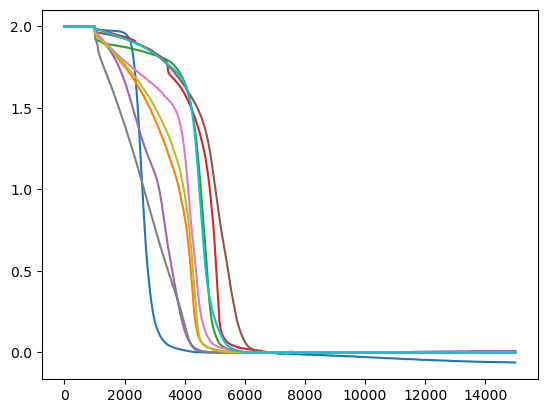

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 

X1 = np.load("results_backwards/sigma_scale_0.01.npy")
print(X1[:, -1:])
for i in range(X1.shape[0]):
        plt.plot(X1[i])